In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import datetime

%pip install keras-tuner --upgrade
import keras_tuner
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers.schedules import ExponentialDecay

def calculate_smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))


def plot_loss(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.show()


def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 0])
        Y.append(data[(i+look_back), 0])
    return np.array(X), np.array(Y)


def build_model(hp, train_shape, look_back):
    model = Sequential()
    #  if hp is passed then tune hyperparameters
    if hp:
        model.add(LSTM(units=hp.Int('lstm_units_1', min_value=32, max_value=366, step=32), return_sequences=False, input_shape=(look_back, 1)))
        model.add(Dense(1))
        hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=hp_learning_rate), metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
    else:
        # return_sequences = True for stacked LSTM, where last LSTM layer must have return_sequences = False!
        model.add(LSTM(units=100, return_sequences=False, input_shape=(look_back, 1)))
        model.add(Dense(1))
        model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

def split_data(df, offset, train_size, test_size):
    train_data = df.loc[df.index.min() + pd.DateOffset(days=offset) : df.index.min() + pd.DateOffset(days=offset) + pd.DateOffset(months=train_size)]

    # If there is no number_of_test_values left in the df to the end, then train and test should be none
    if train_data.index.max() + pd.DateOffset(days=test_size) > df.index.max():
        return None, None, None, None, None, None

    test_data = df.loc[train_data.index.max() + pd.DateOffset(days=1) : train_data.index.max() + pd.DateOffset(days=test_size)]

    start_date, slice_date, end_date = train_data.index.min(), train_data.index.max(), test_data.index.max()

    scaler = MinMaxScaler(feature_range=(0,1))
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)

    return train_data, test_data, scaler, start_date, slice_date, end_date

def train_LSTM_model(train_data, look_back, batch_size, epochs, tune_hyperparameters):
    # Prepare input and output for LSTM model
    x_train, y_train = create_dataset(train_data, look_back)

    # LSTM expects inputs to be shaped as (batch_size, timesteps, channels) or (num_samples, timesteps, features)
    x_train = np.reshape(x_train, (x_train.shape[0], look_back, 1))

    # Splitting the last val_size of data for validation
    val_size = int(0.1 * len(x_train))
    x_train, y_train = x_train[:-val_size], y_train[:-val_size]
    x_val, y_val = x_train[-val_size:], y_train[-val_size:]

    early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

    if tune_hyperparameters:
        # Training the model
        tuner = keras_tuner.Hyperband(
                            # must be wrapped in lambda because build_model() takes more than hp as argument
                            hypermodel=lambda hp: build_model(hp, x_train.shape[0], look_back),
                            objective=[keras_tuner.Objective("val_loss", "min")],
                            max_epochs=10,
                            overwrite=True,
                            project_name='LSTM_hyperparameter_tuning'
                            )
        tuner.search(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stop])
        best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
        print("\nBest hyperparameters: \n")
        print(best_hps.values)

        model = tuner.hypermodel.build(best_hps)
    else:
        model = build_model(hp=None, train_shape=x_train.shape[0], look_back=look_back)

    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0,
                        validation_data=(x_val, y_val), callbacks=[early_stop])


    return model, history

def test_LSTM_model(model, train_data, test_data, look_back, scaler):
    # Testing the model using sequential predictions
    # making test set: x_test[0] = x_train[-5:]; x_test[1] = x_train[-4:],x_test[0]; x_test[2] = x_train[-3:],x_test[0],x_test[1] and so on
    x_test = train_data[-look_back:]
    y_test = test_data
    testPredict = []

    for i in range(0, len(test_data)):
        x_test, y_test = np.array(x_test), np.array(y_test)
        x_test = np.reshape(x_test, (1, look_back, 1))
        y_pred = model.predict(x_test, verbose=0)
        # append y_pred value to testPredict
        testPredict.append(y_pred[0][0])
        # push the predictions to the end of the test set so it pushes out first value
        x_test = np.append(x_test, y_pred[0][0])
        # x_test = np.append(x_test, y_test[i][0])
        x_test = x_test[1:]

    testPredict = np.reshape(testPredict, (-1,1))
    testPredict = scaler.inverse_transform(testPredict)
    y_test = scaler.inverse_transform(y_test)

    mae = mean_absolute_error(y_test, testPredict)
    rmse = np.sqrt(mean_squared_error(y_test, testPredict))
    r2 = r2_score(y_test, testPredict)
    smape = calculate_smape(y_test, testPredict)

    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R2 Score:", r2)
    print("SMAPE:", smape)

    return rmse, mae, r2, smape, testPredict, y_test

In [ ]:
# Write experiment data to file
dir_name = 'Results'
file_name = 'LSTM_experiment_results.csv'
results_file_path = os.path.join(dir_name, file_name)

# Create the directory if it doesn't exist
os.makedirs(dir_name, exist_ok=True)

# Experiment parameters
tune_hyperparameters = False
epochs = 10

# train_size represents the number of months to be used for training (e.g. 4*12 is 4 years, 6 is 0.5 years)
# test_sizes represents the number of days to be used for testing (e.g. 4*7 is 4 weeks)
experiment_cases = [
    # {'input_dir': "Dataset", 'filename': "dataset_aqi_daily.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},
    # {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},
    # {'input_dir': "Dataset", 'filename': "dataset_aqi_daily_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},
    # {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},

    # {'input_dir': "Dataset", 'filename': "dataset_aqi_daily.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},
    # {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},
    # Amina
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]},
    # Emina
     {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]}
]

for experiment_case in experiment_cases:
    input_dir = experiment_case['input_dir']
    #input_dir = "/content/gdrive/MyDrive/AirQuality/AQI prediction code/AQI_PM2.5/Dataset"
    filename = experiment_case['filename']
    label = experiment_case['label']
    train_size = experiment_case['train_size']
    test_sizes = experiment_case['test_sizes']

    if 'hourly' in filename:
        look_back = 5
        batch_size = 128
    if 'daily' in filename:
        look_back = 3
        batch_size = 30

    # Load the CSV file
    df = pd.read_csv(os.path.join(input_dir,filename))
    df.DateTime = pd.to_datetime(df.DateTime)
    df = df.set_index('DateTime')

    print(f'\nRunning experiment for {filename} with label {label}:\n')
    for test_size in test_sizes:
        offset = 0 # start from the beginning of the dataframe
        while True:
            train_data, test_data, scaler, start_date, slice_date, end_date = split_data(df, offset, train_size, test_size)

            if train_data is None or test_data is None:
                print(f'No more data for test size {test_size} days')
                break

            offset += 7 # move train+test window forward by 7 days for next iteration

            # if start_date == pd.to_datetime('2021-03-30 17:00:00'):
            #     print(f'Offset = {offset}')
            #     break

            model, history = train_LSTM_model(train_data, look_back, batch_size, epochs, tune_hyperparameters)

            rmse, mae, r2, smape, testPredict, y_test = test_LSTM_model(model, train_data, test_data, look_back, scaler)

            # Prepare data for CSV
            data = {
                'DateTime of experiment': [datetime.datetime.now()],
                'Dataset used': [filename],
                'Label predicted': [label],
                'Training data from': [start_date],
                'Training data to': [slice_date],
                'Testing data from': [slice_date],
                'Testing data to': [end_date],
                'Test size': [len(test_data)],
                'look_back': [look_back],
                'batch_size': [batch_size],
                'epochs': [epochs],
                # 'Model configuration': [json.dumps(model.get_config())],
                'Test Predictions': [testPredict.tolist()],
                'Test Data': [y_test.tolist()],
                'RMSE': [rmse],
                'MAE': [mae],
                'R2': [r2],
                'SMAPE': [smape]
            }

            # print finished iteration
            print(f'Finished iteration offset={offset} days train_size={train_size} months test_size={test_size} days\n')

            # Convert to DataFrame
            df_result = pd.DataFrame(data)

            # Write DataFrame to CSV
            df_result.to_csv(results_file_path, mode='a', header=not os.path.exists(results_file_path), index=False)


Results for dataset_aqi_hourly.csv with label AQI, train_size=12 months, test_size=28 days:

Errors for 1 days:
MAE: 36.31899636334692
RMSE: 50.365732799304446
R2: 0.3706397573931367
SMAPE: 45.21477758262632
Errors for 7 days:
MAE: 73.60401959129985
RMSE: 106.22985438900528
R2: -1.9341325796764046
SMAPE: 69.09245279714203
Errors for 14 days:
MAE: 84.4759027071085
RMSE: 138.9997460605382
R2: -4.029978753769988
SMAPE: 66.04233933107697
Errors for 28 days:
MAE: 96.33956457508351
RMSE: 164.2943154123945
R2: -6.465744375260686
SMAPE: 73.22179697175024


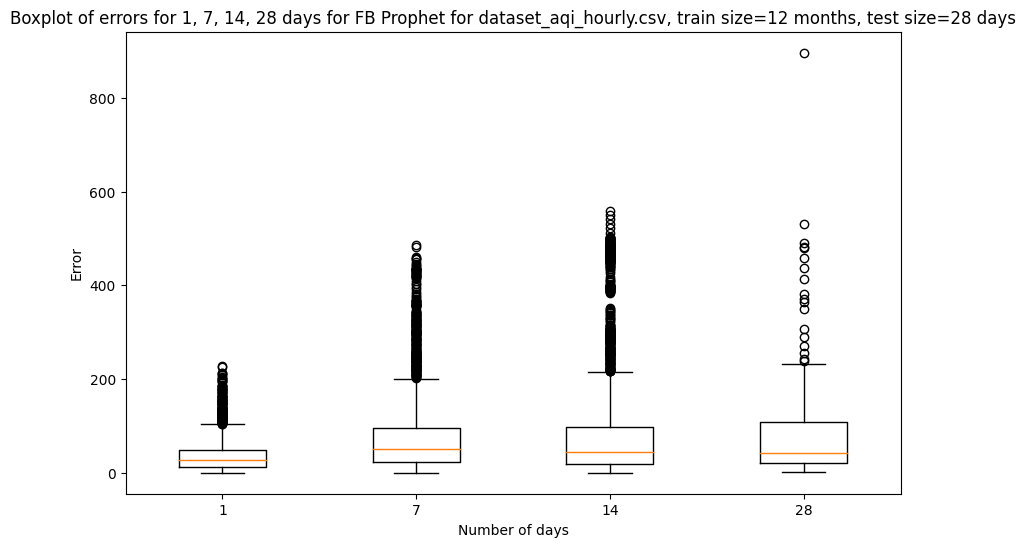

In [ ]:
df_results = pd.read_csv(results_file_path)

# convert to datetime
df_results['DateTime of experiment'] = pd.to_datetime(df_results['DateTime of experiment'])
df_results['Training data from'] = pd.to_datetime(df_results['Training data from'])
df_results['Training data to'] = pd.to_datetime(df_results['Training data to'])
df_results['Testing data from'] = pd.to_datetime(df_results['Testing data from'])
df_results['Testing data to'] = pd.to_datetime(df_results['Testing data to'])
# convert Test Data and Test Predictions to lists of doubles
df_results['Test Data'] = df_results['Test Data'].apply(lambda x: [item[0] for item in json.loads(x)])
df_results['Test Predictions'] = df_results['Test Predictions'].apply(lambda x: [item[0] for item in json.loads(x)])
# calculate time delta in months round to 0 decimals
df_results['Training Duration'] = ((df_results['Training data to'] - df_results['Training data from']) / np.timedelta64(1, 'M')).round(0).astype(int)
df_results['Testing duration'] = ((df_results['Testing data to'] - df_results['Testing data from']) / np.timedelta64(1, 'D')).round(0).astype(int)

for experiment_case in experiment_cases:
    filename = experiment_case['filename']
    label = experiment_case['label']
    train_size = experiment_case['train_size']
    test_sizes = experiment_case['test_sizes']

    print(f'\nResults for {filename} with label {label}, train_size={train_size} months, test_size={test_sizes[0]} days:\n')

    df_results_filtered = df_results[(df_results['Dataset used'] == filename) & (df_results['Label predicted'] == label) & (df_results['Training Duration'] == train_size) & (df_results['Testing duration'] == test_sizes[0])]

    # Columns that contain list of predictions for each experiment
    tests_column = df_results_filtered['Test Data']
    predictions_column = df_results_filtered['Test Predictions']

    test_data_for_periods = []
    prediction_data_for_periods = []

    # Calculating errors for 1, 7, 14, 28 days and plotting forecast plot and boxplot
    for i in [1, 7, 14, 28]:
        # take i-1-th (-1 because enumerations starts from 0) element from each list of tests and predictions columns
        if 'daily' in filename:
            tests = tests_column.apply(lambda x: x[i-1])
            predictions = predictions_column.apply(lambda x: x[i-1])
        elif 'hourly' in filename:
            tests = pd.Series([item for sublist in tests_column.apply(lambda x: x[(i-1)*24:i*24]) for item in sublist])
            predictions = pd.Series([item for sublist in predictions_column.apply(lambda x: x[(i-1)*24:i*24]) for item in sublist])

        test_data_for_periods.append(tests)
        prediction_data_for_periods.append(predictions)

        # Calculate errors
        mae = mean_absolute_error(tests, predictions)
        rmse = np.sqrt(mean_squared_error(tests, predictions))
        r2 = r2_score(tests, predictions)
        smape = calculate_smape(tests, predictions)

        print(f'Errors for {i} days:')
        print(f'MAE: {mae}')
        print(f'RMSE: {rmse}')
        print(f'R2: {r2}')
        print(f'SMAPE: {smape}')

    # Plot boxplot of errors as error = abs(predictions - tests) for 1, 7, 14, 28 days on one plot where x label shows number of days
    plt.figure(figsize=(10,6))
    plt.boxplot([abs(test_data_for_periods[0] - prediction_data_for_periods[0]), abs(test_data_for_periods[1] - prediction_data_for_periods[1]), abs(test_data_for_periods[2] - prediction_data_for_periods[2]), abs(test_data_for_periods[3] - prediction_data_for_periods[3])])
    plt.xticks([1, 2, 3, 4], [1, 7, 14, 28])
    plt.xlabel('Number of days')
    plt.ylabel('Error')
    plt.title(f'Boxplot of errors for 1, 7, 14, 28 days for FB Prophet for {filename}, train size={train_size} months, test size={test_sizes[0]} days')
    plt.show()